In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

## Feature extraction

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

## Reinforcement Learning

### Data Preparation

In [10]:
def train_test_data(ticker, industry_sector, n_tickers, trading_window, min_year=2007, train_max_year=2016):
    
    #Ticker selection
    if ticker is not None:
        tickers = [ticker]
    else:
        #Get list of tickers based on selected industry 
        tickers_lookup = pd.read_csv('tickers_lookup.csv')
        tickers = tickers_lookup[tickers_lookup.INDUSTRY_SECTOR==industry_sector].sort_values('CUR_MKT_CAP',ascending=False)
        tickers = tickers.iloc[:n_tickers]['file_name'] #pick top n tickers by market cap
        tickers = [ticker[:len(ticker)-4] for ticker in tickers] #remove .txt extension
    
    #Empty dataframes to hold full sets of training and test data
    features_train = pd.DataFrame()
    features_test = pd.DataFrame()
    raw_data_train = pd.DataFrame()
    raw_data_test = pd.DataFrame()
    
    for ticker in tickers:
        features_i, raw_data_i = create_features(ticker,trading_window)
        features_i['ticker'] = ticker
        raw_data_i['ticker'] = ticker
        
        #Only keep data after min_year
        features_i['Year'] = pd.to_datetime(features_i.index.values).year
        features_i = features_i.loc[features_i['Year']>min_year]
        raw_data_i = raw_data_i.loc[features_i.index]

        #Split training & testing sets (data points after train_max_year are used for testing)
        features_train_i = features_i.loc[features_i['Year']<train_max_year]
        raw_data_train_i = raw_data_i.loc[features_train_i.index]

        features_test_i = features_i.loc[features_i['Year']>=train_max_year]
        raw_data_test_i = raw_data_i.loc[features_test_i.index]

        #Append to full set of features and raw_data
        features_train = features_train.append(features_train_i)
        raw_data_train = raw_data_train.append(raw_data_train_i)
        features_test = features_test.append(features_test_i)
        raw_data_test = raw_data_test.append(raw_data_test_i)
    
    
    #Remove Year column from features
    features_train = features_train.drop(['Year'], axis = 1)
    features_test = features_test.drop(['Year'], axis = 1)
    
    return features_train, features_test, raw_data_train, raw_data_test

In [11]:
ticker = None
industry_sector = 'Industrial'
n_tickers = 30
trading_window = 21
min_year = 2007
train_max_year = 2016

features_train, features_test, raw_data_train, raw_data_test = train_test_data(ticker,industry_sector,n_tickers,trading_window,min_year,train_max_year)

In [12]:
print('# of total samples: ' + str(features_train.shape[0]+features_test.shape[0]))
print('# of training samples: ' + str(features_train.shape[0]))
print('# of test samples: ' + str(features_test.shape[0]))

# of total samples: 71896
# of training samples: 58025
# of test samples: 13871


### Training

In [76]:
#IPython extension to reload modules, so that kernel does not need to be restarted for every change in the Gym environment
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up environment for training:

In [131]:
import gym
import gym_market
import numpy as np
import imp

pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_train, 
                  'raw_data':raw_data_train}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Test environment:

In [132]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0]
Rewards: [0.44999999999999996, -3.71, -3.61, -3.68, -0.72, 1.32, -0.83, -3.73, -0.75, -3.8200000000000003, 1.2, -0.95, -1.1, -3.85, 1.1400000000000001, 0.08999999999999997, 0.020000000000000018, -2.98, -0.030000000000000027, -3.04, -1.19]
Return: 0.9693660958909669


In [133]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

Neural net architecture:

In [134]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [135]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [136]:
train_episodes = 6000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0005            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.001          # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [137]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)

Populate memory:

In [138]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [139]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -25.790000000000003 Training loss: 3.3911 Explore P: 0.9990 Total return: 1.21
Episode: 2 Total reward: -28.250000000000004 Training loss: 2.3642 Explore P: 0.9979 Total return: 1.00
Episode: 3 Total reward: -34.38999999999999 Training loss: 2.6299 Explore P: 0.9969 Total return: 0.58
Episode: 4 Total reward: -32.14 Training loss: 2.9089 Explore P: 0.9959 Total return: 0.95
Episode: 5 Total reward: -35.830000000000005 Training loss: 2.6967 Explore P: 0.9948 Total return: 0.59
Episode: 6 Total reward: -27.95 Training loss: 2.9108 Explore P: 0.9938 Total return: 0.93
Episode: 7 Total reward: -25.410000000000007 Training loss: 2.2230 Explore P: 0.9928 Total return: 1.03
Episode: 8 Total reward: -29.48 Training loss: 2.6074 Explore P: 0.9917 Total return: 0.95
Episode: 9 Total reward: -24.420000000000005 Training loss: 2.8871 Explore P: 0.9907 Total return: 1.08
Episode: 10 Total reward: -20.710000000000004 Training loss: 2.9142 Explore P: 0.9897 Total return: 1.06

Episode: 86 Total reward: -31.21 Training loss: 3.6343 Explore P: 0.9145 Total return: 0.99
Episode: 87 Total reward: -30.66 Training loss: 4.2038 Explore P: 0.9136 Total return: 0.97
Episode: 88 Total reward: -29.509999999999998 Training loss: 3.4859 Explore P: 0.9126 Total return: 0.99
Episode: 89 Total reward: -29.0 Training loss: 2.3732 Explore P: 0.9117 Total return: 0.83
Episode: 90 Total reward: -32.17 Training loss: 4.1580 Explore P: 0.9107 Total return: 1.00
Episode: 91 Total reward: -24.270000000000003 Training loss: 3.8176 Explore P: 0.9098 Total return: 1.04
Episode: 92 Total reward: -25.470000000000002 Training loss: 1.3873 Explore P: 0.9088 Total return: 1.09
Episode: 93 Total reward: -41.72999999999999 Training loss: 3.4611 Explore P: 0.9079 Total return: 0.92
Episode: 94 Total reward: -23.99 Training loss: 3.4776 Explore P: 0.9070 Total return: 1.00
Episode: 95 Total reward: -24.619999999999997 Training loss: 4.2857 Explore P: 0.9060 Total return: 1.03
Episode: 96 Total

Episode: 170 Total reward: -34.5 Training loss: 2.8332 Explore P: 0.8382 Total return: 0.89
Episode: 171 Total reward: -23.8 Training loss: 3.0793 Explore P: 0.8373 Total return: 1.04
Episode: 172 Total reward: -35.800000000000004 Training loss: 3.6427 Explore P: 0.8364 Total return: 1.02
Episode: 173 Total reward: -13.49 Training loss: 3.0325 Explore P: 0.8356 Total return: 1.05
Episode: 174 Total reward: -33.68 Training loss: 2.5357 Explore P: 0.8347 Total return: 0.87
Episode: 175 Total reward: -31.259999999999998 Training loss: 3.2691 Explore P: 0.8338 Total return: 1.09
Episode: 176 Total reward: -42.3 Training loss: 1.8334 Explore P: 0.8330 Total return: 0.83
Episode: 177 Total reward: -32.14000000000001 Training loss: 3.4941 Explore P: 0.8321 Total return: 0.88
Episode: 178 Total reward: -44.14000000000001 Training loss: 3.1269 Explore P: 0.8312 Total return: 0.79
Episode: 179 Total reward: -36.32 Training loss: 1.7968 Explore P: 0.8304 Total return: 0.91
Episode: 180 Total rewa

Episode: 254 Total reward: -38.739999999999995 Training loss: 2.7326 Explore P: 0.7682 Total return: 0.93
Episode: 255 Total reward: -21.260000000000005 Training loss: 2.5375 Explore P: 0.7674 Total return: 0.97
Episode: 256 Total reward: -30.490000000000002 Training loss: 3.2261 Explore P: 0.7667 Total return: 0.96
Episode: 257 Total reward: -27.180000000000003 Training loss: 2.7860 Explore P: 0.7659 Total return: 0.93
Episode: 258 Total reward: -22.310000000000002 Training loss: 2.3928 Explore P: 0.7651 Total return: 1.03
Episode: 259 Total reward: -22.5 Training loss: 4.7013 Explore P: 0.7643 Total return: 0.98
Episode: 260 Total reward: -38.919999999999995 Training loss: 2.3912 Explore P: 0.7635 Total return: 0.89
Episode: 261 Total reward: -20.909999999999997 Training loss: 2.0894 Explore P: 0.7627 Total return: 1.04
Episode: 262 Total reward: -24.819999999999997 Training loss: 4.8874 Explore P: 0.7619 Total return: 0.95
Episode: 263 Total reward: -25.2 Training loss: 2.0022 Explo

Episode: 338 Total reward: -25.140000000000004 Training loss: 2.2367 Explore P: 0.7042 Total return: 1.02
Episode: 339 Total reward: -35.38999999999999 Training loss: 2.5546 Explore P: 0.7035 Total return: 0.95
Episode: 340 Total reward: -10.650000000000004 Training loss: 2.3788 Explore P: 0.7028 Total return: 1.05
Episode: 341 Total reward: -32.88 Training loss: 2.0326 Explore P: 0.7020 Total return: 0.98
Episode: 342 Total reward: -21.82 Training loss: 1.7072 Explore P: 0.7013 Total return: 1.01
Episode: 343 Total reward: -31.68 Training loss: 2.6581 Explore P: 0.7006 Total return: 0.99
Episode: 344 Total reward: -28.040000000000003 Training loss: 2.6420 Explore P: 0.6999 Total return: 0.96
Episode: 345 Total reward: -28.070000000000004 Training loss: 3.7792 Explore P: 0.6991 Total return: 0.81
Episode: 346 Total reward: -19.760000000000005 Training loss: 4.0789 Explore P: 0.6984 Total return: 0.99
Episode: 347 Total reward: -14.640000000000002 Training loss: 2.5837 Explore P: 0.6977

Episode: 422 Total reward: -32.28 Training loss: 2.3099 Explore P: 0.6456 Total return: 0.93
Episode: 423 Total reward: -35.18 Training loss: 1.8970 Explore P: 0.6450 Total return: 0.97
Episode: 424 Total reward: -27.079999999999995 Training loss: 1.8294 Explore P: 0.6443 Total return: 0.95
Episode: 425 Total reward: -22.0 Training loss: 2.5870 Explore P: 0.6436 Total return: 1.04
Episode: 426 Total reward: -23.830000000000005 Training loss: 2.4319 Explore P: 0.6430 Total return: 1.02
Episode: 427 Total reward: -12.689999999999998 Training loss: 2.7212 Explore P: 0.6423 Total return: 1.15
Episode: 428 Total reward: -27.640000000000004 Training loss: 4.0301 Explore P: 0.6416 Total return: 1.01
Episode: 429 Total reward: -33.46 Training loss: 2.2398 Explore P: 0.6410 Total return: 0.90
Episode: 430 Total reward: -24.719999999999995 Training loss: 2.6012 Explore P: 0.6403 Total return: 0.93
Episode: 431 Total reward: -23.699999999999996 Training loss: 3.6904 Explore P: 0.6396 Total return

Episode: 506 Total reward: -25.900000000000006 Training loss: 3.7545 Explore P: 0.5920 Total return: 0.95
Episode: 507 Total reward: -23.439999999999998 Training loss: 1.0030 Explore P: 0.5914 Total return: 1.04
Episode: 508 Total reward: -16.91 Training loss: 1.8509 Explore P: 0.5907 Total return: 1.07
Episode: 509 Total reward: -22.75 Training loss: 1.9177 Explore P: 0.5901 Total return: 1.00
Episode: 510 Total reward: -28.189999999999998 Training loss: 1.9825 Explore P: 0.5895 Total return: 0.48
Episode: 511 Total reward: -15.14 Training loss: 2.9143 Explore P: 0.5889 Total return: 1.08
Episode: 512 Total reward: -24.639999999999997 Training loss: 2.0689 Explore P: 0.5883 Total return: 0.88
Episode: 513 Total reward: -34.13000000000001 Training loss: 2.1837 Explore P: 0.5877 Total return: 1.03
Episode: 514 Total reward: -26.780000000000005 Training loss: 2.7509 Explore P: 0.5871 Total return: 0.94
Episode: 515 Total reward: -30.120000000000005 Training loss: 2.8209 Explore P: 0.5865

Episode: 590 Total reward: -30.85 Training loss: 2.6848 Explore P: 0.5428 Total return: 0.86
Episode: 591 Total reward: -23.950000000000003 Training loss: 1.5514 Explore P: 0.5423 Total return: 0.97
Episode: 592 Total reward: -21.39 Training loss: 1.8476 Explore P: 0.5417 Total return: 0.95
Episode: 593 Total reward: -23.62 Training loss: 2.5358 Explore P: 0.5412 Total return: 1.00
Episode: 594 Total reward: -20.870000000000005 Training loss: 2.8501 Explore P: 0.5406 Total return: 0.97
Episode: 595 Total reward: -23.310000000000006 Training loss: 2.7560 Explore P: 0.5400 Total return: 0.99
Episode: 596 Total reward: -17.770000000000003 Training loss: 3.2114 Explore P: 0.5395 Total return: 1.00
Episode: 597 Total reward: -19.720000000000002 Training loss: 2.2674 Explore P: 0.5389 Total return: 1.02
Episode: 598 Total reward: -21.05 Training loss: 1.5508 Explore P: 0.5384 Total return: 1.02
Episode: 599 Total reward: -20.840000000000007 Training loss: 1.8894 Explore P: 0.5378 Total retur

Episode: 674 Total reward: -31.070000000000004 Training loss: 4.1395 Explore P: 0.4978 Total return: 0.74
Episode: 675 Total reward: -27.3 Training loss: 2.5710 Explore P: 0.4973 Total return: 1.05
Episode: 676 Total reward: -22.21 Training loss: 2.0182 Explore P: 0.4968 Total return: 1.01
Episode: 677 Total reward: -15.920000000000002 Training loss: 2.4649 Explore P: 0.4963 Total return: 1.05
Episode: 678 Total reward: -22.919999999999998 Training loss: 3.0277 Explore P: 0.4958 Total return: 1.01
Episode: 679 Total reward: -24.18 Training loss: 2.4010 Explore P: 0.4953 Total return: 0.97
Episode: 680 Total reward: -18.260000000000005 Training loss: 2.1996 Explore P: 0.4948 Total return: 1.00
Episode: 681 Total reward: -35.940000000000005 Training loss: 1.7252 Explore P: 0.4943 Total return: 0.90
Episode: 682 Total reward: -34.459999999999994 Training loss: 2.6732 Explore P: 0.4938 Total return: 0.89
Episode: 683 Total reward: -28.37 Training loss: 2.8172 Explore P: 0.4933 Total return

Episode: 758 Total reward: -26.499999999999996 Training loss: 2.7337 Explore P: 0.4567 Total return: 0.99
Episode: 759 Total reward: -36.47 Training loss: 1.9440 Explore P: 0.4562 Total return: 0.87
Episode: 760 Total reward: -25.249999999999996 Training loss: 1.8941 Explore P: 0.4557 Total return: 1.02
Episode: 761 Total reward: -17.660000000000004 Training loss: 1.7943 Explore P: 0.4553 Total return: 1.05
Episode: 762 Total reward: -26.58 Training loss: 2.4776 Explore P: 0.4548 Total return: 0.93
Episode: 763 Total reward: -20.030000000000005 Training loss: 2.5545 Explore P: 0.4543 Total return: 1.04
Episode: 764 Total reward: -29.27 Training loss: 2.3720 Explore P: 0.4539 Total return: 0.96
Episode: 765 Total reward: -24.14 Training loss: 1.2882 Explore P: 0.4534 Total return: 1.01
Episode: 766 Total reward: -27.110000000000007 Training loss: 2.0547 Explore P: 0.4529 Total return: 0.93
Episode: 767 Total reward: -22.990000000000006 Training loss: 2.0548 Explore P: 0.4525 Total retur

Episode: 842 Total reward: -19.12 Training loss: 1.2602 Explore P: 0.4190 Total return: 1.01
Episode: 843 Total reward: -31.76 Training loss: 2.5548 Explore P: 0.4185 Total return: 0.93
Episode: 844 Total reward: -30.800000000000004 Training loss: 2.0989 Explore P: 0.4181 Total return: 0.79
Episode: 845 Total reward: -23.23 Training loss: 2.0198 Explore P: 0.4177 Total return: 1.02
Episode: 846 Total reward: -28.839999999999996 Training loss: 2.2095 Explore P: 0.4172 Total return: 1.00
Episode: 847 Total reward: -20.34 Training loss: 1.5959 Explore P: 0.4168 Total return: 1.03
Episode: 848 Total reward: -14.559999999999999 Training loss: 1.8326 Explore P: 0.4164 Total return: 1.08
Episode: 849 Total reward: -25.71 Training loss: 1.4983 Explore P: 0.4160 Total return: 0.97
Episode: 850 Total reward: -19.290000000000003 Training loss: 1.9108 Explore P: 0.4155 Total return: 0.97
Episode: 851 Total reward: -21.26 Training loss: 2.4371 Explore P: 0.4151 Total return: 1.07
Episode: 852 Total

Episode: 926 Total reward: -20.970000000000006 Training loss: 2.3619 Explore P: 0.3844 Total return: 0.93
Episode: 927 Total reward: -29.74 Training loss: 2.3684 Explore P: 0.3840 Total return: 0.97
Episode: 928 Total reward: -25.590000000000003 Training loss: 2.2807 Explore P: 0.3836 Total return: 0.94
Episode: 929 Total reward: -21.110000000000003 Training loss: 1.4278 Explore P: 0.3833 Total return: 1.06
Episode: 930 Total reward: -25.54 Training loss: 1.4225 Explore P: 0.3829 Total return: 0.85
Episode: 931 Total reward: -29.340000000000003 Training loss: 2.1050 Explore P: 0.3825 Total return: 0.96
Episode: 932 Total reward: -23.319999999999997 Training loss: 1.5512 Explore P: 0.3821 Total return: 1.05
Episode: 933 Total reward: -25.830000000000002 Training loss: 1.9189 Explore P: 0.3817 Total return: 0.96
Episode: 934 Total reward: -24.56 Training loss: 2.1382 Explore P: 0.3813 Total return: 1.00
Episode: 935 Total reward: -40.81999999999999 Training loss: 1.8558 Explore P: 0.3809

Episode: 1010 Total reward: -22.46 Training loss: 1.6688 Explore P: 0.3528 Total return: 1.05
Episode: 1011 Total reward: -24.77 Training loss: 1.3530 Explore P: 0.3525 Total return: 0.99
Episode: 1012 Total reward: -17.689999999999998 Training loss: 1.1641 Explore P: 0.3521 Total return: 0.99
Episode: 1013 Total reward: -30.68 Training loss: 0.9984 Explore P: 0.3517 Total return: 0.83
Episode: 1014 Total reward: -13.780000000000001 Training loss: 2.7147 Explore P: 0.3514 Total return: 1.09
Episode: 1015 Total reward: -13.79 Training loss: 2.3606 Explore P: 0.3510 Total return: 1.04
Episode: 1016 Total reward: -24.129999999999995 Training loss: 1.7183 Explore P: 0.3507 Total return: 0.93
Episode: 1017 Total reward: -23.540000000000003 Training loss: 1.7729 Explore P: 0.3503 Total return: 0.97
Episode: 1018 Total reward: -28.589999999999996 Training loss: 0.4375 Explore P: 0.3500 Total return: 1.00
Episode: 1019 Total reward: -24.599999999999998 Training loss: 1.0021 Explore P: 0.3496 T

Episode: 1094 Total reward: -17.26 Training loss: 2.9834 Explore P: 0.3239 Total return: 1.00
Episode: 1095 Total reward: -23.04 Training loss: 1.1371 Explore P: 0.3235 Total return: 0.96
Episode: 1096 Total reward: -23.69 Training loss: 1.8594 Explore P: 0.3232 Total return: 1.01
Episode: 1097 Total reward: -24.019999999999996 Training loss: 1.4719 Explore P: 0.3229 Total return: 1.05
Episode: 1098 Total reward: -21.099999999999998 Training loss: 3.3254 Explore P: 0.3226 Total return: 1.00
Episode: 1099 Total reward: -36.03 Training loss: 1.2251 Explore P: 0.3222 Total return: 0.80
Episode: 1100 Total reward: -24.79 Training loss: 1.6505 Explore P: 0.3219 Total return: 0.82
Episode: 1101 Total reward: -25.7 Training loss: 1.7279 Explore P: 0.3216 Total return: 0.97
Episode: 1102 Total reward: -21.590000000000003 Training loss: 1.3244 Explore P: 0.3213 Total return: 1.00
Episode: 1103 Total reward: -35.11000000000001 Training loss: 1.6744 Explore P: 0.3209 Total return: 0.95
Episode: 1

Episode: 1175 Total reward: -15.74 Training loss: 1.5710 Explore P: 0.2983 Total return: 1.04
Episode: 1176 Total reward: -24.320000000000004 Training loss: 1.4136 Explore P: 0.2980 Total return: 0.86
Episode: 1177 Total reward: -28.39 Training loss: 2.1350 Explore P: 0.2977 Total return: 1.01
Episode: 1178 Total reward: -21.709999999999997 Training loss: 1.4766 Explore P: 0.2974 Total return: 1.11
Episode: 1179 Total reward: -26.560000000000002 Training loss: 2.3922 Explore P: 0.2971 Total return: 0.96
Episode: 1180 Total reward: -33.370000000000005 Training loss: 1.7967 Explore P: 0.2968 Total return: 0.96
Episode: 1181 Total reward: -20.17 Training loss: 1.5683 Explore P: 0.2965 Total return: 1.03
Episode: 1182 Total reward: -33.27 Training loss: 2.0221 Explore P: 0.2962 Total return: 0.93
Episode: 1183 Total reward: -23.590000000000003 Training loss: 1.4322 Explore P: 0.2959 Total return: 1.00
Episode: 1184 Total reward: -33.08 Training loss: 2.4450 Explore P: 0.2956 Total return: 

Episode: 1259 Total reward: -14.409999999999997 Training loss: 0.9953 Explore P: 0.2739 Total return: 0.96
Episode: 1260 Total reward: -12.640000000000004 Training loss: 1.1028 Explore P: 0.2737 Total return: 1.11
Episode: 1261 Total reward: -16.65 Training loss: 2.3065 Explore P: 0.2734 Total return: 1.14
Episode: 1262 Total reward: -25.609999999999996 Training loss: 1.5019 Explore P: 0.2731 Total return: 0.87
Episode: 1263 Total reward: -22.070000000000004 Training loss: 1.3853 Explore P: 0.2728 Total return: 1.11
Episode: 1264 Total reward: -30.79 Training loss: 1.4995 Explore P: 0.2726 Total return: 0.94
Episode: 1265 Total reward: -29.099999999999998 Training loss: 1.4183 Explore P: 0.2723 Total return: 0.94
Episode: 1266 Total reward: -21.78 Training loss: 1.0000 Explore P: 0.2720 Total return: 0.93
Episode: 1267 Total reward: -23.41 Training loss: 2.8284 Explore P: 0.2717 Total return: 0.98
Episode: 1268 Total reward: -25.16 Training loss: 1.4214 Explore P: 0.2715 Total return: 

Episode: 1340 Total reward: -31.750000000000007 Training loss: 0.6860 Explore P: 0.2524 Total return: 0.93
Episode: 1341 Total reward: -25.900000000000002 Training loss: 1.0292 Explore P: 0.2522 Total return: 1.01
Episode: 1342 Total reward: -24.84 Training loss: 2.4330 Explore P: 0.2519 Total return: 0.99
Episode: 1343 Total reward: -22.169999999999998 Training loss: 0.8743 Explore P: 0.2517 Total return: 1.03
Episode: 1344 Total reward: -17.950000000000003 Training loss: 1.5923 Explore P: 0.2514 Total return: 1.12
Episode: 1345 Total reward: -23.32 Training loss: 1.4757 Explore P: 0.2512 Total return: 1.06
Episode: 1346 Total reward: -26.97 Training loss: 1.3424 Explore P: 0.2509 Total return: 1.03
Episode: 1347 Total reward: -16.509999999999998 Training loss: 1.0247 Explore P: 0.2507 Total return: 1.01
Episode: 1348 Total reward: -22.070000000000004 Training loss: 1.9429 Explore P: 0.2504 Total return: 0.99
Episode: 1349 Total reward: -18.749999999999996 Training loss: 1.5422 Explor

Episode: 1424 Total reward: -18.849999999999998 Training loss: 0.9995 Explore P: 0.2320 Total return: 1.03
Episode: 1425 Total reward: -24.409999999999997 Training loss: 0.9703 Explore P: 0.2317 Total return: 0.94
Episode: 1426 Total reward: -18.81 Training loss: 1.5184 Explore P: 0.2315 Total return: 1.01
Episode: 1427 Total reward: -20.17 Training loss: 1.6755 Explore P: 0.2313 Total return: 0.96
Episode: 1428 Total reward: -21.87 Training loss: 2.1501 Explore P: 0.2310 Total return: 0.99
Episode: 1429 Total reward: -19.619999999999997 Training loss: 2.1876 Explore P: 0.2308 Total return: 0.94
Episode: 1430 Total reward: -20.099999999999998 Training loss: 1.2923 Explore P: 0.2306 Total return: 1.08
Episode: 1431 Total reward: -16.97 Training loss: 2.7568 Explore P: 0.2303 Total return: 1.13
Episode: 1432 Total reward: -28.330000000000002 Training loss: 2.2245 Explore P: 0.2301 Total return: 0.97
Episode: 1433 Total reward: -12.84 Training loss: 1.5458 Explore P: 0.2299 Total return: 

Episode: 1507 Total reward: -24.48 Training loss: 3.5001 Explore P: 0.2134 Total return: 0.88
Episode: 1508 Total reward: -15.130000000000003 Training loss: 1.6080 Explore P: 0.2132 Total return: 1.00
Episode: 1509 Total reward: -21.650000000000002 Training loss: 2.3720 Explore P: 0.2130 Total return: 1.04
Episode: 1510 Total reward: -17.330000000000002 Training loss: 1.2166 Explore P: 0.2128 Total return: 1.09
Episode: 1511 Total reward: -28.049999999999997 Training loss: 0.9037 Explore P: 0.2126 Total return: 0.94
Episode: 1512 Total reward: -18.529999999999998 Training loss: 1.7537 Explore P: 0.2124 Total return: 1.01
Episode: 1513 Total reward: -24.1 Training loss: 1.9347 Explore P: 0.2122 Total return: 1.06
Episode: 1514 Total reward: -13.959999999999999 Training loss: 1.9169 Explore P: 0.2119 Total return: 1.02
Episode: 1515 Total reward: -17.459999999999997 Training loss: 1.5648 Explore P: 0.2117 Total return: 1.00
Episode: 1516 Total reward: -20.930000000000003 Training loss: 1

Episode: 1589 Total reward: -35.18 Training loss: 1.2185 Explore P: 0.1967 Total return: 0.57
Episode: 1590 Total reward: -21.710000000000004 Training loss: 2.2708 Explore P: 0.1965 Total return: 1.14
Episode: 1591 Total reward: -27.180000000000003 Training loss: 1.8764 Explore P: 0.1963 Total return: 0.96
Episode: 1592 Total reward: -26.939999999999998 Training loss: 2.3329 Explore P: 0.1961 Total return: 0.96
Episode: 1593 Total reward: -33.03 Training loss: 1.5539 Explore P: 0.1959 Total return: 0.97
Episode: 1594 Total reward: -23.060000000000002 Training loss: 1.2704 Explore P: 0.1957 Total return: 0.99
Episode: 1595 Total reward: -28.270000000000003 Training loss: 1.7106 Explore P: 0.1955 Total return: 0.97
Episode: 1596 Total reward: -14.48 Training loss: 3.0868 Explore P: 0.1953 Total return: 1.03
Episode: 1597 Total reward: -15.799999999999997 Training loss: 1.1472 Explore P: 0.1951 Total return: 1.01
Episode: 1598 Total reward: -16.54 Training loss: 2.4633 Explore P: 0.1949 T

Episode: 1670 Total reward: -19.17 Training loss: 2.6546 Explore P: 0.1814 Total return: 1.02
Episode: 1671 Total reward: -18.110000000000003 Training loss: 0.8860 Explore P: 0.1813 Total return: 1.07
Episode: 1672 Total reward: -29.800000000000004 Training loss: 1.2682 Explore P: 0.1811 Total return: 1.00
Episode: 1673 Total reward: -32.46 Training loss: 3.2276 Explore P: 0.1809 Total return: 0.92
Episode: 1674 Total reward: -17.13 Training loss: 2.8076 Explore P: 0.1807 Total return: 1.01
Episode: 1675 Total reward: -14.280000000000001 Training loss: 1.6196 Explore P: 0.1805 Total return: 1.08
Episode: 1676 Total reward: -26.93 Training loss: 2.3915 Explore P: 0.1804 Total return: 1.04
Episode: 1677 Total reward: -27.880000000000003 Training loss: 2.4794 Explore P: 0.1802 Total return: 0.94
Episode: 1678 Total reward: -12.989999999999998 Training loss: 2.1167 Explore P: 0.1800 Total return: 1.04
Episode: 1679 Total reward: -14.759999999999998 Training loss: 1.8214 Explore P: 0.1798 T

Episode: 1751 Total reward: -24.579999999999995 Training loss: 2.4620 Explore P: 0.1675 Total return: 0.94
Episode: 1752 Total reward: -18.360000000000003 Training loss: 1.1877 Explore P: 0.1673 Total return: 0.98
Episode: 1753 Total reward: -25.13 Training loss: 1.4660 Explore P: 0.1671 Total return: 0.94
Episode: 1754 Total reward: -21.270000000000003 Training loss: 2.0535 Explore P: 0.1670 Total return: 0.99
Episode: 1755 Total reward: -28.550000000000004 Training loss: 2.0038 Explore P: 0.1668 Total return: 1.09
Episode: 1756 Total reward: -24.63 Training loss: 1.6978 Explore P: 0.1666 Total return: 1.01
Episode: 1757 Total reward: -24.880000000000003 Training loss: 1.1204 Explore P: 0.1665 Total return: 0.95
Episode: 1758 Total reward: -21.740000000000002 Training loss: 1.5513 Explore P: 0.1663 Total return: 0.96
Episode: 1759 Total reward: -27.11 Training loss: 3.0881 Explore P: 0.1661 Total return: 0.99
Episode: 1760 Total reward: -23.97 Training loss: 0.9479 Explore P: 0.1660 T

Episode: 1835 Total reward: -26.41 Training loss: 1.7836 Explore P: 0.1542 Total return: 1.01
Episode: 1836 Total reward: -18.44 Training loss: 2.2927 Explore P: 0.1540 Total return: 1.05
Episode: 1837 Total reward: -16.139999999999997 Training loss: 0.9559 Explore P: 0.1539 Total return: 1.05
Episode: 1838 Total reward: -22.579999999999995 Training loss: 2.7743 Explore P: 0.1537 Total return: 1.01
Episode: 1839 Total reward: -21.94 Training loss: 1.8030 Explore P: 0.1536 Total return: 0.99
Episode: 1840 Total reward: -18.920000000000005 Training loss: 1.5844 Explore P: 0.1534 Total return: 0.97
Episode: 1841 Total reward: -16.990000000000002 Training loss: 2.4616 Explore P: 0.1533 Total return: 1.03
Episode: 1842 Total reward: -19.61 Training loss: 1.6084 Explore P: 0.1531 Total return: 0.86
Episode: 1843 Total reward: -16.0 Training loss: 1.1562 Explore P: 0.1530 Total return: 1.00
Episode: 1844 Total reward: -24.610000000000003 Training loss: 1.5060 Explore P: 0.1528 Total return: 0

Episode: 1919 Total reward: -29.540000000000003 Training loss: 1.1916 Explore P: 0.1420 Total return: 0.84
Episode: 1920 Total reward: -18.279999999999998 Training loss: 1.1873 Explore P: 0.1419 Total return: 0.99
Episode: 1921 Total reward: -25.590000000000003 Training loss: 1.5927 Explore P: 0.1417 Total return: 0.95
Episode: 1922 Total reward: -12.530000000000001 Training loss: 1.8222 Explore P: 0.1416 Total return: 1.03
Episode: 1923 Total reward: -22.400000000000002 Training loss: 1.0031 Explore P: 0.1414 Total return: 1.01
Episode: 1924 Total reward: -19.95 Training loss: 1.5205 Explore P: 0.1413 Total return: 1.00
Episode: 1925 Total reward: -18.91 Training loss: 1.5199 Explore P: 0.1412 Total return: 1.08
Episode: 1926 Total reward: -27.88 Training loss: 1.1717 Explore P: 0.1410 Total return: 0.97
Episode: 1927 Total reward: -16.89 Training loss: 0.9296 Explore P: 0.1409 Total return: 1.04
Episode: 1928 Total reward: -20.310000000000002 Training loss: 1.0328 Explore P: 0.1408 T

Episode: 2000 Total reward: -24.650000000000006 Training loss: 2.2763 Explore P: 0.1312 Total return: 0.98
Episode: 2001 Total reward: -19.04 Training loss: 1.7041 Explore P: 0.1311 Total return: 0.96
Episode: 2002 Total reward: -21.56 Training loss: 1.2332 Explore P: 0.1310 Total return: 0.90
Episode: 2003 Total reward: -18.119999999999997 Training loss: 1.7664 Explore P: 0.1309 Total return: 1.02
Episode: 2004 Total reward: -18.269999999999996 Training loss: 0.5435 Explore P: 0.1307 Total return: 1.03
Episode: 2005 Total reward: -20.299999999999997 Training loss: 1.8258 Explore P: 0.1306 Total return: 0.98
Episode: 2006 Total reward: -15.530000000000001 Training loss: 1.2438 Explore P: 0.1305 Total return: 1.08
Episode: 2007 Total reward: -18.45 Training loss: 1.4540 Explore P: 0.1303 Total return: 1.00
Episode: 2008 Total reward: -32.61 Training loss: 1.5135 Explore P: 0.1302 Total return: 0.90
Episode: 2009 Total reward: -27.270000000000003 Training loss: 2.0989 Explore P: 0.1301 T

Episode: 2084 Total reward: -22.84999999999999 Training loss: 1.3136 Explore P: 0.1210 Total return: 0.93
Episode: 2085 Total reward: -12.380000000000003 Training loss: 2.6918 Explore P: 0.1209 Total return: 1.14
Episode: 2086 Total reward: -21.550000000000004 Training loss: 1.5287 Explore P: 0.1208 Total return: 0.96
Episode: 2087 Total reward: -18.720000000000002 Training loss: 1.0347 Explore P: 0.1206 Total return: 1.01
Episode: 2088 Total reward: -25.819999999999997 Training loss: 2.3069 Explore P: 0.1205 Total return: 1.02
Episode: 2089 Total reward: -18.01 Training loss: 1.0735 Explore P: 0.1204 Total return: 1.08
Episode: 2090 Total reward: -16.44 Training loss: 1.4041 Explore P: 0.1203 Total return: 1.12
Episode: 2091 Total reward: -23.799999999999997 Training loss: 1.0993 Explore P: 0.1202 Total return: 0.92
Episode: 2092 Total reward: -12.86 Training loss: 1.7649 Explore P: 0.1201 Total return: 1.12
Episode: 2093 Total reward: -18.75 Training loss: 2.1107 Explore P: 0.1200 To

Episode: 2165 Total reward: -15.78 Training loss: 1.6634 Explore P: 0.1119 Total return: 1.07
Episode: 2166 Total reward: -29.259999999999998 Training loss: 1.9876 Explore P: 0.1118 Total return: 0.93
Episode: 2167 Total reward: -23.17 Training loss: 1.0385 Explore P: 0.1117 Total return: 0.98
Episode: 2168 Total reward: -16.419999999999998 Training loss: 2.1299 Explore P: 0.1116 Total return: 1.00
Episode: 2169 Total reward: -31.26 Training loss: 0.9546 Explore P: 0.1115 Total return: 0.88
Episode: 2170 Total reward: -22.769999999999996 Training loss: 1.6418 Explore P: 0.1114 Total return: 1.04
Episode: 2171 Total reward: -14.25 Training loss: 1.6346 Explore P: 0.1113 Total return: 1.05
Episode: 2172 Total reward: -23.32 Training loss: 1.8123 Explore P: 0.1112 Total return: 1.05
Episode: 2173 Total reward: -19.57 Training loss: 1.8483 Explore P: 0.1111 Total return: 0.97
Episode: 2174 Total reward: -14.45 Training loss: 1.6779 Explore P: 0.1110 Total return: 1.01
Episode: 2175 Total r

Episode: 2249 Total reward: -24.62 Training loss: 1.3716 Explore P: 0.1033 Total return: 1.01
Episode: 2250 Total reward: -13.31 Training loss: 1.8685 Explore P: 0.1032 Total return: 1.11
Episode: 2251 Total reward: -23.49 Training loss: 1.4718 Explore P: 0.1031 Total return: 1.06
Episode: 2252 Total reward: -23.619999999999997 Training loss: 2.2649 Explore P: 0.1030 Total return: 0.98
Episode: 2253 Total reward: -21.659999999999997 Training loss: 1.9966 Explore P: 0.1029 Total return: 0.97
Episode: 2254 Total reward: -17.06 Training loss: 1.6868 Explore P: 0.1029 Total return: 1.11
Episode: 2255 Total reward: -20.299999999999997 Training loss: 1.8016 Explore P: 0.1028 Total return: 0.99
Episode: 2256 Total reward: -23.580000000000005 Training loss: 2.4668 Explore P: 0.1027 Total return: 0.99
Episode: 2257 Total reward: -17.8 Training loss: 2.0545 Explore P: 0.1026 Total return: 0.99
Episode: 2258 Total reward: -26.01 Training loss: 1.0975 Explore P: 0.1025 Total return: 0.89
Episode: 

Episode: 2333 Total reward: -26.61 Training loss: 1.9738 Explore P: 0.0955 Total return: 0.78
Episode: 2334 Total reward: -16.459999999999997 Training loss: 1.8877 Explore P: 0.0954 Total return: 1.03
Episode: 2335 Total reward: -13.989999999999997 Training loss: 1.7851 Explore P: 0.0953 Total return: 1.09
Episode: 2336 Total reward: -18.319999999999997 Training loss: 1.5708 Explore P: 0.0952 Total return: 0.98
Episode: 2337 Total reward: -27.490000000000002 Training loss: 1.0475 Explore P: 0.0951 Total return: 0.84
Episode: 2338 Total reward: -18.259999999999998 Training loss: 1.2974 Explore P: 0.0950 Total return: 1.02
Episode: 2339 Total reward: -23.609999999999996 Training loss: 1.1240 Explore P: 0.0949 Total return: 0.98
Episode: 2340 Total reward: -23.990000000000002 Training loss: 1.9150 Explore P: 0.0948 Total return: 0.94
Episode: 2341 Total reward: -15.940000000000001 Training loss: 1.7934 Explore P: 0.0947 Total return: 1.11
Episode: 2342 Total reward: -23.450000000000006 Tr

Episode: 2414 Total reward: -34.01 Training loss: 1.5904 Explore P: 0.0885 Total return: 0.89
Episode: 2415 Total reward: -26.91 Training loss: 1.4837 Explore P: 0.0884 Total return: 0.79
Episode: 2416 Total reward: -21.509999999999998 Training loss: 1.4669 Explore P: 0.0883 Total return: 1.03
Episode: 2417 Total reward: -14.92 Training loss: 0.9784 Explore P: 0.0882 Total return: 1.13
Episode: 2418 Total reward: -26.279999999999998 Training loss: 2.8907 Explore P: 0.0882 Total return: 0.98
Episode: 2419 Total reward: -21.56 Training loss: 1.6828 Explore P: 0.0881 Total return: 0.94
Episode: 2420 Total reward: -22.999999999999996 Training loss: 1.1185 Explore P: 0.0880 Total return: 1.03
Episode: 2421 Total reward: -20.849999999999998 Training loss: 1.0741 Explore P: 0.0879 Total return: 1.00
Episode: 2422 Total reward: -18.479999999999997 Training loss: 1.8678 Explore P: 0.0878 Total return: 1.02
Episode: 2423 Total reward: -20.45 Training loss: 1.4913 Explore P: 0.0878 Total return: 

Episode: 2498 Total reward: -20.61 Training loss: 2.0091 Explore P: 0.0819 Total return: 1.01
Episode: 2499 Total reward: -26.1 Training loss: 2.3521 Explore P: 0.0818 Total return: 1.09
Episode: 2500 Total reward: -24.189999999999994 Training loss: 2.0602 Explore P: 0.0817 Total return: 0.94
Episode: 2501 Total reward: -20.089999999999996 Training loss: 1.1133 Explore P: 0.0816 Total return: 0.97
Episode: 2502 Total reward: -18.76 Training loss: 1.6598 Explore P: 0.0816 Total return: 0.99
Episode: 2503 Total reward: -16.64 Training loss: 1.5721 Explore P: 0.0815 Total return: 1.09
Episode: 2504 Total reward: -15.629999999999999 Training loss: 2.1693 Explore P: 0.0814 Total return: 1.11
Episode: 2505 Total reward: -19.889999999999997 Training loss: 1.4964 Explore P: 0.0813 Total return: 1.03
Episode: 2506 Total reward: -25.86 Training loss: 1.8477 Explore P: 0.0813 Total return: 0.86
Episode: 2507 Total reward: -19.310000000000002 Training loss: 1.4235 Explore P: 0.0812 Total return: 0

Episode: 2582 Total reward: -15.669999999999998 Training loss: 1.1681 Explore P: 0.0758 Total return: 0.99
Episode: 2583 Total reward: -13.36 Training loss: 2.2028 Explore P: 0.0757 Total return: 1.02
Episode: 2584 Total reward: -45.15 Training loss: 1.6318 Explore P: 0.0757 Total return: 1.00
Episode: 2585 Total reward: -26.160000000000004 Training loss: 1.2791 Explore P: 0.0756 Total return: 0.96
Episode: 2586 Total reward: -27.859999999999992 Training loss: 2.7099 Explore P: 0.0755 Total return: 0.99
Episode: 2587 Total reward: -19.84 Training loss: 2.0865 Explore P: 0.0755 Total return: 0.96
Episode: 2588 Total reward: -22.670000000000005 Training loss: 1.4071 Explore P: 0.0754 Total return: 0.97
Episode: 2589 Total reward: -26.410000000000004 Training loss: 0.6276 Explore P: 0.0753 Total return: 0.97
Episode: 2590 Total reward: -14.030000000000001 Training loss: 1.9604 Explore P: 0.0752 Total return: 1.05
Episode: 2591 Total reward: -15.879999999999999 Training loss: 1.6905 Explor

Episode: 2665 Total reward: -14.45 Training loss: 1.0559 Explore P: 0.0703 Total return: 1.00
Episode: 2666 Total reward: -19.470000000000002 Training loss: 1.2078 Explore P: 0.0702 Total return: 0.97
Episode: 2667 Total reward: -19.09 Training loss: 1.1703 Explore P: 0.0702 Total return: 0.99
Episode: 2668 Total reward: -21.410000000000004 Training loss: 0.9393 Explore P: 0.0701 Total return: 0.96
Episode: 2669 Total reward: -18.740000000000006 Training loss: 1.6892 Explore P: 0.0701 Total return: 1.08
Episode: 2670 Total reward: -14.370000000000001 Training loss: 1.2567 Explore P: 0.0700 Total return: 1.06
Episode: 2671 Total reward: -21.19 Training loss: 1.8306 Explore P: 0.0699 Total return: 1.04
Episode: 2672 Total reward: -19.47 Training loss: 1.3591 Explore P: 0.0699 Total return: 0.95
Episode: 2673 Total reward: -27.81 Training loss: 1.1126 Explore P: 0.0698 Total return: 0.87
Episode: 2674 Total reward: -19.15 Training loss: 0.9544 Explore P: 0.0697 Total return: 1.00
Episode:

Episode: 2747 Total reward: -24.85 Training loss: 1.4104 Explore P: 0.0653 Total return: 0.98
Episode: 2748 Total reward: -20.439999999999998 Training loss: 1.1951 Explore P: 0.0653 Total return: 0.97
Episode: 2749 Total reward: -23.629999999999995 Training loss: 0.9440 Explore P: 0.0652 Total return: 1.02
Episode: 2750 Total reward: -14.45 Training loss: 1.1020 Explore P: 0.0652 Total return: 1.00
Episode: 2751 Total reward: -17.9 Training loss: 2.2238 Explore P: 0.0651 Total return: 1.00
Episode: 2752 Total reward: -18.369999999999997 Training loss: 1.7428 Explore P: 0.0650 Total return: 0.95
Episode: 2753 Total reward: -13.659999999999998 Training loss: 1.6137 Explore P: 0.0650 Total return: 1.04
Episode: 2754 Total reward: -15.16 Training loss: 0.9358 Explore P: 0.0649 Total return: 0.99
Episode: 2755 Total reward: -19.47 Training loss: 0.7864 Explore P: 0.0649 Total return: 0.99
Episode: 2756 Total reward: -14.45 Training loss: 0.9775 Explore P: 0.0648 Total return: 1.03
Episode: 

Episode: 2830 Total reward: -25.530000000000005 Training loss: 1.3075 Explore P: 0.0607 Total return: 0.99
Episode: 2831 Total reward: -17.8 Training loss: 1.8069 Explore P: 0.0607 Total return: 0.98
Episode: 2832 Total reward: -26.150000000000002 Training loss: 1.1892 Explore P: 0.0606 Total return: 0.97
Episode: 2833 Total reward: -24.11 Training loss: 1.6902 Explore P: 0.0606 Total return: 1.01
Episode: 2834 Total reward: -27.880000000000006 Training loss: 1.3298 Explore P: 0.0605 Total return: 0.98
Episode: 2835 Total reward: -20.52 Training loss: 1.4247 Explore P: 0.0604 Total return: 0.95
Episode: 2836 Total reward: -13.8 Training loss: 2.5424 Explore P: 0.0604 Total return: 1.02
Episode: 2837 Total reward: -20.37 Training loss: 1.3326 Explore P: 0.0603 Total return: 0.95
Episode: 2838 Total reward: -26.34 Training loss: 0.7411 Explore P: 0.0603 Total return: 0.96
Episode: 2839 Total reward: -16.110000000000003 Training loss: 1.0595 Explore P: 0.0602 Total return: 1.00
Episode: 2

Episode: 2914 Total reward: -24.71 Training loss: 1.1162 Explore P: 0.0564 Total return: 1.00
Episode: 2915 Total reward: -16.57 Training loss: 0.9972 Explore P: 0.0564 Total return: 1.03
Episode: 2916 Total reward: -14.549999999999999 Training loss: 1.7146 Explore P: 0.0563 Total return: 1.05
Episode: 2917 Total reward: -29.560000000000002 Training loss: 0.9865 Explore P: 0.0563 Total return: 0.66
Episode: 2918 Total reward: -21.54 Training loss: 0.9829 Explore P: 0.0562 Total return: 0.95
Episode: 2919 Total reward: -22.86 Training loss: 1.9850 Explore P: 0.0562 Total return: 1.03
Episode: 2920 Total reward: -10.679999999999998 Training loss: 1.8359 Explore P: 0.0561 Total return: 1.06
Episode: 2921 Total reward: -32.43 Training loss: 0.3463 Explore P: 0.0561 Total return: 0.69
Episode: 2922 Total reward: -30.419999999999995 Training loss: 1.1760 Explore P: 0.0560 Total return: 0.89
Episode: 2923 Total reward: -19.849999999999998 Training loss: 0.7709 Explore P: 0.0560 Total return: 

Episode: 2997 Total reward: -29.64 Training loss: 1.6977 Explore P: 0.0526 Total return: 0.83
Episode: 2998 Total reward: -25.67 Training loss: 1.9983 Explore P: 0.0525 Total return: 0.95
Episode: 2999 Total reward: -18.930000000000003 Training loss: 0.3187 Explore P: 0.0525 Total return: 1.05
Episode: 3000 Total reward: -26.67 Training loss: 1.0847 Explore P: 0.0524 Total return: 0.94
Episode: 3001 Total reward: -16.419999999999998 Training loss: 0.7625 Explore P: 0.0524 Total return: 1.03
Episode: 3002 Total reward: -18.52 Training loss: 0.7149 Explore P: 0.0523 Total return: 1.04
Episode: 3003 Total reward: -19.150000000000006 Training loss: 1.4464 Explore P: 0.0523 Total return: 0.92
Episode: 3004 Total reward: -23.639999999999997 Training loss: 1.6039 Explore P: 0.0522 Total return: 1.03
Episode: 3005 Total reward: -30.669999999999995 Training loss: 0.7354 Explore P: 0.0522 Total return: 0.94
Episode: 3006 Total reward: -18.239999999999995 Training loss: 1.0537 Explore P: 0.0522 T

Episode: 3081 Total reward: -19.46 Training loss: 1.8954 Explore P: 0.0490 Total return: 1.06
Episode: 3082 Total reward: -13.899999999999999 Training loss: 1.1046 Explore P: 0.0489 Total return: 1.07
Episode: 3083 Total reward: -14.46 Training loss: 2.1954 Explore P: 0.0489 Total return: 1.07
Episode: 3084 Total reward: -18.45 Training loss: 2.4005 Explore P: 0.0488 Total return: 1.00
Episode: 3085 Total reward: -25.960000000000004 Training loss: 3.3533 Explore P: 0.0488 Total return: 1.03
Episode: 3086 Total reward: -22.190000000000005 Training loss: 1.2745 Explore P: 0.0488 Total return: 1.11
Episode: 3087 Total reward: -18.949999999999996 Training loss: 0.8021 Explore P: 0.0487 Total return: 0.95
Episode: 3088 Total reward: -18.99 Training loss: 1.2818 Explore P: 0.0487 Total return: 0.98
Episode: 3089 Total reward: -25.060000000000002 Training loss: 1.8255 Explore P: 0.0486 Total return: 0.91
Episode: 3090 Total reward: -18.56 Training loss: 1.6519 Explore P: 0.0486 Total return: 

Episode: 3165 Total reward: -20.13 Training loss: 1.2304 Explore P: 0.0457 Total return: 1.03
Episode: 3166 Total reward: -19.830000000000002 Training loss: 2.1820 Explore P: 0.0456 Total return: 0.97
Episode: 3167 Total reward: -20.6 Training loss: 0.4878 Explore P: 0.0456 Total return: 0.97
Episode: 3168 Total reward: -26.820000000000004 Training loss: 1.7365 Explore P: 0.0456 Total return: 0.97
Episode: 3169 Total reward: -13.079999999999998 Training loss: 1.7778 Explore P: 0.0455 Total return: 0.95
Episode: 3170 Total reward: -16.92 Training loss: 1.8937 Explore P: 0.0455 Total return: 1.04
Episode: 3171 Total reward: -29.5 Training loss: 1.5578 Explore P: 0.0455 Total return: 0.95
Episode: 3172 Total reward: -26.63 Training loss: 1.4001 Explore P: 0.0454 Total return: 0.93
Episode: 3173 Total reward: -27.160000000000004 Training loss: 0.6597 Explore P: 0.0454 Total return: 0.90
Episode: 3174 Total reward: -18.69 Training loss: 0.9766 Explore P: 0.0453 Total return: 1.04
Episode: 3

Episode: 3248 Total reward: -19.9 Training loss: 1.9125 Explore P: 0.0427 Total return: 1.01
Episode: 3249 Total reward: -14.32 Training loss: 2.2493 Explore P: 0.0427 Total return: 1.01
Episode: 3250 Total reward: -26.899999999999995 Training loss: 1.0649 Explore P: 0.0426 Total return: 0.97
Episode: 3251 Total reward: -14.03 Training loss: 1.7871 Explore P: 0.0426 Total return: 1.05
Episode: 3252 Total reward: -21.220000000000002 Training loss: 2.0715 Explore P: 0.0426 Total return: 1.01
Episode: 3253 Total reward: -21.210000000000004 Training loss: 1.4042 Explore P: 0.0425 Total return: 0.94
Episode: 3254 Total reward: -21.83 Training loss: 1.5928 Explore P: 0.0425 Total return: 0.94
Episode: 3255 Total reward: -14.32 Training loss: 1.9640 Explore P: 0.0425 Total return: 1.02
Episode: 3256 Total reward: -28.369999999999994 Training loss: 2.0528 Explore P: 0.0424 Total return: 0.93
Episode: 3257 Total reward: -20.37 Training loss: 0.7409 Explore P: 0.0424 Total return: 1.02
Episode: 

Episode: 3332 Total reward: -15.86 Training loss: 0.7435 Explore P: 0.0399 Total return: 1.03
Episode: 3333 Total reward: -14.45 Training loss: 1.8818 Explore P: 0.0399 Total return: 1.03
Episode: 3334 Total reward: -16.179999999999996 Training loss: 0.9770 Explore P: 0.0399 Total return: 1.04
Episode: 3335 Total reward: -14.45 Training loss: 1.2628 Explore P: 0.0398 Total return: 1.02
Episode: 3336 Total reward: -17.389999999999997 Training loss: 2.3692 Explore P: 0.0398 Total return: 1.05
Episode: 3337 Total reward: -17.310000000000002 Training loss: 1.2896 Explore P: 0.0398 Total return: 1.05
Episode: 3338 Total reward: -21.779999999999998 Training loss: 1.7065 Explore P: 0.0397 Total return: 0.97
Episode: 3339 Total reward: -23.85 Training loss: 0.6759 Explore P: 0.0397 Total return: 1.06
Episode: 3340 Total reward: -13.739999999999998 Training loss: 1.4135 Explore P: 0.0397 Total return: 1.02
Episode: 3341 Total reward: -18.22 Training loss: 1.2874 Explore P: 0.0397 Total return: 

Episode: 3416 Total reward: -14.56 Training loss: 2.2755 Explore P: 0.0374 Total return: 1.06
Episode: 3417 Total reward: -14.12 Training loss: 1.1326 Explore P: 0.0374 Total return: 1.07
Episode: 3418 Total reward: -26.810000000000002 Training loss: 1.4017 Explore P: 0.0374 Total return: 0.99
Episode: 3419 Total reward: -15.580000000000002 Training loss: 0.8618 Explore P: 0.0373 Total return: 1.04
Episode: 3420 Total reward: -16.87 Training loss: 0.4709 Explore P: 0.0373 Total return: 1.04
Episode: 3421 Total reward: -19.269999999999996 Training loss: 1.0912 Explore P: 0.0373 Total return: 0.97
Episode: 3422 Total reward: -17.23 Training loss: 0.8958 Explore P: 0.0372 Total return: 0.98
Episode: 3423 Total reward: -23.760000000000005 Training loss: 1.3876 Explore P: 0.0372 Total return: 0.93
Episode: 3424 Total reward: -20.27 Training loss: 1.5612 Explore P: 0.0372 Total return: 1.01
Episode: 3425 Total reward: -20.41 Training loss: 1.0375 Explore P: 0.0372 Total return: 1.03
Episode:

Episode: 3498 Total reward: -21.2 Training loss: 1.0226 Explore P: 0.0351 Total return: 0.97
Episode: 3499 Total reward: -18.5 Training loss: 0.9777 Explore P: 0.0351 Total return: 1.03
Episode: 3500 Total reward: -14.13 Training loss: 2.2998 Explore P: 0.0351 Total return: 1.03
Episode: 3501 Total reward: -17.429999999999996 Training loss: 2.3317 Explore P: 0.0351 Total return: 1.02
Episode: 3502 Total reward: -14.099999999999998 Training loss: 0.8974 Explore P: 0.0350 Total return: 1.08
Episode: 3503 Total reward: -25.34 Training loss: 1.6684 Explore P: 0.0350 Total return: 0.78
Episode: 3504 Total reward: -24.080000000000002 Training loss: 1.0613 Explore P: 0.0350 Total return: 0.98
Episode: 3505 Total reward: -31.460000000000004 Training loss: 1.4837 Explore P: 0.0350 Total return: 0.96
Episode: 3506 Total reward: -20.429999999999996 Training loss: 1.4606 Explore P: 0.0349 Total return: 1.01
Episode: 3507 Total reward: -21.599999999999998 Training loss: 0.5949 Explore P: 0.0349 Tot

Episode: 3582 Total reward: -20.020000000000007 Training loss: 0.7446 Explore P: 0.0330 Total return: 1.01
Episode: 3583 Total reward: -21.57 Training loss: 2.0516 Explore P: 0.0330 Total return: 1.00
Episode: 3584 Total reward: -23.189999999999998 Training loss: 0.7766 Explore P: 0.0330 Total return: 1.01
Episode: 3585 Total reward: -14.32 Training loss: 2.1763 Explore P: 0.0330 Total return: 1.03
Episode: 3586 Total reward: -23.760000000000005 Training loss: 1.2329 Explore P: 0.0329 Total return: 0.91
Episode: 3587 Total reward: -9.960000000000003 Training loss: 1.5379 Explore P: 0.0329 Total return: 1.11
Episode: 3588 Total reward: -24.369999999999997 Training loss: 1.3683 Explore P: 0.0329 Total return: 0.90
Episode: 3589 Total reward: -16.16 Training loss: 0.9092 Explore P: 0.0329 Total return: 1.01
Episode: 3590 Total reward: -22.569999999999997 Training loss: 1.9501 Explore P: 0.0328 Total return: 0.97
Episode: 3591 Total reward: -10.67 Training loss: 0.9274 Explore P: 0.0328 To

Episode: 3663 Total reward: -14.45 Training loss: 1.1662 Explore P: 0.0311 Total return: 1.00
Episode: 3664 Total reward: -16.099999999999998 Training loss: 2.2103 Explore P: 0.0311 Total return: 1.02
Episode: 3665 Total reward: -19.269999999999996 Training loss: 1.3452 Explore P: 0.0311 Total return: 0.99
Episode: 3666 Total reward: -14.27 Training loss: 2.0189 Explore P: 0.0311 Total return: 1.06
Episode: 3667 Total reward: -25.639999999999997 Training loss: 2.5490 Explore P: 0.0311 Total return: 0.83
Episode: 3668 Total reward: -17.590000000000003 Training loss: 1.6233 Explore P: 0.0310 Total return: 1.03
Episode: 3669 Total reward: -23.500000000000004 Training loss: 1.1327 Explore P: 0.0310 Total return: 0.93
Episode: 3670 Total reward: -22.71 Training loss: 2.2127 Explore P: 0.0310 Total return: 0.91
Episode: 3671 Total reward: -14.45 Training loss: 1.2597 Explore P: 0.0310 Total return: 1.02
Episode: 3672 Total reward: -19.459999999999997 Training loss: 1.8180 Explore P: 0.0309 T

Episode: 3744 Total reward: -15.29 Training loss: 1.7778 Explore P: 0.0294 Total return: 1.00
Episode: 3745 Total reward: -23.040000000000003 Training loss: 0.4990 Explore P: 0.0294 Total return: 0.97
Episode: 3746 Total reward: -23.490000000000002 Training loss: 1.6104 Explore P: 0.0294 Total return: 0.93
Episode: 3747 Total reward: -19.69 Training loss: 1.4891 Explore P: 0.0294 Total return: 0.96
Episode: 3748 Total reward: -14.860000000000003 Training loss: 1.5492 Explore P: 0.0293 Total return: 0.99
Episode: 3749 Total reward: -18.239999999999995 Training loss: 1.0733 Explore P: 0.0293 Total return: 1.04
Episode: 3750 Total reward: -22.85 Training loss: 1.8596 Explore P: 0.0293 Total return: 0.96
Episode: 3751 Total reward: -19.889999999999997 Training loss: 1.0465 Explore P: 0.0293 Total return: 0.96
Episode: 3752 Total reward: -23.459999999999997 Training loss: 1.5369 Explore P: 0.0293 Total return: 0.96
Episode: 3753 Total reward: -14.45 Training loss: 2.8944 Explore P: 0.0292 T

Episode: 3828 Total reward: -14.71 Training loss: 1.4098 Explore P: 0.0278 Total return: 1.07
Episode: 3829 Total reward: -19.390000000000004 Training loss: 0.4693 Explore P: 0.0278 Total return: 1.03
Episode: 3830 Total reward: -19.49 Training loss: 1.4163 Explore P: 0.0277 Total return: 1.02
Episode: 3831 Total reward: -19.41 Training loss: 0.7013 Explore P: 0.0277 Total return: 0.96
Episode: 3832 Total reward: -14.290000000000001 Training loss: 1.5988 Explore P: 0.0277 Total return: 1.08
Episode: 3833 Total reward: -24.879999999999992 Training loss: 1.4779 Explore P: 0.0277 Total return: 1.04
Episode: 3834 Total reward: -17.799999999999997 Training loss: 0.9168 Explore P: 0.0277 Total return: 0.99
Episode: 3835 Total reward: -16.759999999999998 Training loss: 1.3955 Explore P: 0.0277 Total return: 1.11
Episode: 3836 Total reward: -27.959999999999997 Training loss: 2.4302 Explore P: 0.0276 Total return: 0.72
Episode: 3837 Total reward: -24.430000000000003 Training loss: 1.6266 Explor

Episode: 3912 Total reward: -20.349999999999998 Training loss: 1.4930 Explore P: 0.0263 Total return: 0.93
Episode: 3913 Total reward: -16.369999999999997 Training loss: 1.5179 Explore P: 0.0263 Total return: 1.02
Episode: 3914 Total reward: -16.46 Training loss: 1.0005 Explore P: 0.0262 Total return: 1.00
Episode: 3915 Total reward: -18.540000000000003 Training loss: 0.2600 Explore P: 0.0262 Total return: 1.07
Episode: 3916 Total reward: -19.040000000000003 Training loss: 0.4204 Explore P: 0.0262 Total return: 1.04
Episode: 3917 Total reward: -19.999999999999996 Training loss: 1.2232 Explore P: 0.0262 Total return: 1.11
Episode: 3918 Total reward: -15.030000000000001 Training loss: 1.7928 Explore P: 0.0262 Total return: 0.98
Episode: 3919 Total reward: -23.42 Training loss: 0.8655 Explore P: 0.0262 Total return: 0.93
Episode: 3920 Total reward: -23.229999999999997 Training loss: 1.1965 Explore P: 0.0261 Total return: 1.01
Episode: 3921 Total reward: -18.45 Training loss: 1.3923 Explor

Episode: 3994 Total reward: -22.789999999999996 Training loss: 1.3381 Explore P: 0.0249 Total return: 0.97
Episode: 3995 Total reward: -19.93 Training loss: 0.4327 Explore P: 0.0249 Total return: 0.93
Episode: 3996 Total reward: -9.129999999999999 Training loss: 1.4113 Explore P: 0.0249 Total return: 1.13
Episode: 3997 Total reward: -30.45 Training loss: 1.4353 Explore P: 0.0249 Total return: 0.91
Episode: 3998 Total reward: -29.000000000000004 Training loss: 1.5797 Explore P: 0.0249 Total return: 0.84
Episode: 3999 Total reward: -20.6 Training loss: 0.9148 Explore P: 0.0249 Total return: 1.06
Episode: 4000 Total reward: -14.93 Training loss: 1.1560 Explore P: 0.0248 Total return: 1.06
Episode: 4001 Total reward: -13.659999999999998 Training loss: 1.4333 Explore P: 0.0248 Total return: 1.04
Episode: 4002 Total reward: -45.15 Training loss: 1.6455 Explore P: 0.0248 Total return: 1.00
Episode: 4003 Total reward: -29.360000000000003 Training loss: 1.3856 Explore P: 0.0248 Total return: 0.

Episode: 4077 Total reward: -15.169999999999998 Training loss: 2.3620 Explore P: 0.0237 Total return: 0.98
Episode: 4078 Total reward: -18.450000000000003 Training loss: 2.0378 Explore P: 0.0237 Total return: 0.99
Episode: 4079 Total reward: -16.51 Training loss: 0.5384 Explore P: 0.0237 Total return: 0.99
Episode: 4080 Total reward: -26.320000000000004 Training loss: 0.9759 Explore P: 0.0236 Total return: 0.98
Episode: 4081 Total reward: -27.609999999999992 Training loss: 1.4364 Explore P: 0.0236 Total return: 0.88
Episode: 4082 Total reward: -15.8 Training loss: 1.0063 Explore P: 0.0236 Total return: 0.96
Episode: 4083 Total reward: -14.45 Training loss: 1.5357 Explore P: 0.0236 Total return: 1.01
Episode: 4084 Total reward: -29.259999999999998 Training loss: 1.1759 Explore P: 0.0236 Total return: 0.96
Episode: 4085 Total reward: -25.700000000000003 Training loss: 1.4803 Explore P: 0.0236 Total return: 0.70
Episode: 4086 Total reward: -18.45 Training loss: 1.0671 Explore P: 0.0236 To

Episode: 4161 Total reward: -25.65 Training loss: 1.3936 Explore P: 0.0225 Total return: 1.04
Episode: 4162 Total reward: -28.400000000000002 Training loss: 1.5721 Explore P: 0.0225 Total return: 0.97
Episode: 4163 Total reward: -19.74 Training loss: 1.4207 Explore P: 0.0225 Total return: 0.98
Episode: 4164 Total reward: -14.52 Training loss: 1.6689 Explore P: 0.0225 Total return: 1.05
Episode: 4165 Total reward: -19.870000000000005 Training loss: 0.8496 Explore P: 0.0225 Total return: 0.97
Episode: 4166 Total reward: -25.700000000000003 Training loss: 1.2290 Explore P: 0.0225 Total return: 0.95
Episode: 4167 Total reward: -26.35 Training loss: 2.2712 Explore P: 0.0225 Total return: 0.72
Episode: 4168 Total reward: -19.469999999999995 Training loss: 1.0280 Explore P: 0.0224 Total return: 0.96
Episode: 4169 Total reward: -18.810000000000006 Training loss: 1.0020 Explore P: 0.0224 Total return: 1.03
Episode: 4170 Total reward: -23.139999999999997 Training loss: 1.0501 Explore P: 0.0224 T

Episode: 4243 Total reward: -45.15 Training loss: 0.9694 Explore P: 0.0215 Total return: 1.00
Episode: 4244 Total reward: -23.400000000000002 Training loss: 1.8302 Explore P: 0.0215 Total return: 1.00
Episode: 4245 Total reward: -15.450000000000001 Training loss: 1.0840 Explore P: 0.0215 Total return: 0.98
Episode: 4246 Total reward: -13.629999999999999 Training loss: 2.0987 Explore P: 0.0215 Total return: 1.02
Episode: 4247 Total reward: -17.46 Training loss: 0.9907 Explore P: 0.0215 Total return: 1.03
Episode: 4248 Total reward: -23.65 Training loss: 1.0257 Explore P: 0.0214 Total return: 1.13
Episode: 4249 Total reward: -15.170000000000002 Training loss: 0.8540 Explore P: 0.0214 Total return: 1.06
Episode: 4250 Total reward: -13.860000000000003 Training loss: 0.5408 Explore P: 0.0214 Total return: 1.02
Episode: 4251 Total reward: -26.25 Training loss: 2.3551 Explore P: 0.0214 Total return: 0.98
Episode: 4252 Total reward: -25.130000000000003 Training loss: 1.3677 Explore P: 0.0214 T

Episode: 4324 Total reward: -14.749999999999998 Training loss: 1.2620 Explore P: 0.0206 Total return: 1.03
Episode: 4325 Total reward: -16.83 Training loss: 1.1340 Explore P: 0.0206 Total return: 0.99
Episode: 4326 Total reward: -14.36 Training loss: 1.3591 Explore P: 0.0205 Total return: 1.00
Episode: 4327 Total reward: -16.23 Training loss: 0.7940 Explore P: 0.0205 Total return: 1.04
Episode: 4328 Total reward: -22.990000000000006 Training loss: 0.3835 Explore P: 0.0205 Total return: 1.08
Episode: 4329 Total reward: -20.71 Training loss: 1.2709 Explore P: 0.0205 Total return: 1.00
Episode: 4330 Total reward: -14.749999999999998 Training loss: 2.1075 Explore P: 0.0205 Total return: 1.03
Episode: 4331 Total reward: -15.829999999999998 Training loss: 1.3515 Explore P: 0.0205 Total return: 0.99
Episode: 4332 Total reward: -30.36 Training loss: 1.8040 Explore P: 0.0205 Total return: 0.96
Episode: 4333 Total reward: -18.880000000000003 Training loss: 0.6883 Explore P: 0.0205 Total return: 

Episode: 4406 Total reward: -23.459999999999997 Training loss: 0.7391 Explore P: 0.0197 Total return: 0.96
Episode: 4407 Total reward: -14.36 Training loss: 1.6227 Explore P: 0.0197 Total return: 1.04
Episode: 4408 Total reward: -13.979999999999999 Training loss: 0.7770 Explore P: 0.0197 Total return: 1.03
Episode: 4409 Total reward: -15.690000000000001 Training loss: 1.0354 Explore P: 0.0197 Total return: 1.10
Episode: 4410 Total reward: -23.550000000000004 Training loss: 1.8518 Explore P: 0.0197 Total return: 0.96
Episode: 4411 Total reward: -15.94 Training loss: 0.9248 Explore P: 0.0196 Total return: 1.08
Episode: 4412 Total reward: -14.57 Training loss: 1.8737 Explore P: 0.0196 Total return: 1.04
Episode: 4413 Total reward: -15.680000000000001 Training loss: 0.8146 Explore P: 0.0196 Total return: 1.05
Episode: 4414 Total reward: -31.56 Training loss: 0.6825 Explore P: 0.0196 Total return: 0.93
Episode: 4415 Total reward: -21.649999999999995 Training loss: 2.1886 Explore P: 0.0196 T

Episode: 4490 Total reward: -22.63 Training loss: 0.6639 Explore P: 0.0189 Total return: 0.99
Episode: 4491 Total reward: -18.279999999999994 Training loss: 0.9065 Explore P: 0.0189 Total return: 0.98
Episode: 4492 Total reward: -17.87 Training loss: 1.0246 Explore P: 0.0189 Total return: 1.08
Episode: 4493 Total reward: -22.459999999999997 Training loss: 0.1732 Explore P: 0.0188 Total return: 0.91
Episode: 4494 Total reward: -20.55 Training loss: 1.2941 Explore P: 0.0188 Total return: 1.03
Episode: 4495 Total reward: -15.240000000000002 Training loss: 1.3835 Explore P: 0.0188 Total return: 1.04
Episode: 4496 Total reward: -14.45 Training loss: 1.3779 Explore P: 0.0188 Total return: 1.02
Episode: 4497 Total reward: -18.09 Training loss: 1.7474 Explore P: 0.0188 Total return: 1.05
Episode: 4498 Total reward: -19.070000000000004 Training loss: 1.6970 Explore P: 0.0188 Total return: 0.97
Episode: 4499 Total reward: -13.969999999999999 Training loss: 0.6197 Explore P: 0.0188 Total return: 

Episode: 4575 Total reward: -20.84 Training loss: 1.7164 Explore P: 0.0181 Total return: 1.07
Episode: 4576 Total reward: -26.349999999999998 Training loss: 1.2986 Explore P: 0.0181 Total return: 0.89
Episode: 4577 Total reward: -23.49 Training loss: 1.2762 Explore P: 0.0181 Total return: 1.08
Episode: 4578 Total reward: -22.120000000000005 Training loss: 1.4019 Explore P: 0.0181 Total return: 0.97
Episode: 4579 Total reward: -19.62 Training loss: 0.9062 Explore P: 0.0181 Total return: 0.91
Episode: 4580 Total reward: -24.119999999999997 Training loss: 1.4831 Explore P: 0.0181 Total return: 0.77
Episode: 4581 Total reward: -19.3 Training loss: 0.4735 Explore P: 0.0181 Total return: 1.02
Episode: 4582 Total reward: -14.879999999999999 Training loss: 1.4223 Explore P: 0.0181 Total return: 1.07
Episode: 4583 Total reward: -19.189999999999998 Training loss: 0.7185 Explore P: 0.0180 Total return: 0.99
Episode: 4584 Total reward: -43.44 Training loss: 1.1769 Explore P: 0.0180 Total return: 0

Episode: 4659 Total reward: -20.590000000000003 Training loss: 0.9295 Explore P: 0.0174 Total return: 1.04
Episode: 4660 Total reward: -22.900000000000002 Training loss: 0.7952 Explore P: 0.0174 Total return: 1.05
Episode: 4661 Total reward: -20.030000000000005 Training loss: 1.4278 Explore P: 0.0174 Total return: 1.02
Episode: 4662 Total reward: -16.400000000000002 Training loss: 1.4610 Explore P: 0.0174 Total return: 1.09
Episode: 4663 Total reward: -20.849999999999998 Training loss: 1.6153 Explore P: 0.0174 Total return: 0.97
Episode: 4664 Total reward: -21.020000000000003 Training loss: 0.3154 Explore P: 0.0174 Total return: 0.95
Episode: 4665 Total reward: -24.450000000000003 Training loss: 0.6975 Explore P: 0.0174 Total return: 1.00
Episode: 4666 Total reward: -14.6 Training loss: 1.0040 Explore P: 0.0174 Total return: 1.04
Episode: 4667 Total reward: -21.51 Training loss: 2.1109 Explore P: 0.0174 Total return: 0.98
Episode: 4668 Total reward: -15.120000000000001 Training loss: 0

Episode: 4743 Total reward: -27.36 Training loss: 1.3060 Explore P: 0.0168 Total return: 0.90
Episode: 4744 Total reward: -15.61 Training loss: 1.4642 Explore P: 0.0168 Total return: 1.04
Episode: 4745 Total reward: -16.419999999999998 Training loss: 1.6742 Explore P: 0.0168 Total return: 1.16
Episode: 4746 Total reward: -15.57 Training loss: 1.5904 Explore P: 0.0168 Total return: 1.12
Episode: 4747 Total reward: -19.069999999999997 Training loss: 0.7856 Explore P: 0.0168 Total return: 0.96
Episode: 4748 Total reward: -13.530000000000001 Training loss: 1.3667 Explore P: 0.0168 Total return: 1.03
Episode: 4749 Total reward: -12.659999999999997 Training loss: 0.9360 Explore P: 0.0168 Total return: 1.00
Episode: 4750 Total reward: -47.39 Training loss: 1.0174 Explore P: 0.0168 Total return: 0.74
Episode: 4751 Total reward: -13.879999999999999 Training loss: 0.5958 Explore P: 0.0167 Total return: 1.01
Episode: 4752 Total reward: -13.82 Training loss: 0.9643 Explore P: 0.0167 Total return: 

Episode: 4827 Total reward: -17.25 Training loss: 1.7691 Explore P: 0.0162 Total return: 1.07
Episode: 4828 Total reward: -16.639999999999997 Training loss: 1.1226 Explore P: 0.0162 Total return: 1.09
Episode: 4829 Total reward: -18.11 Training loss: 0.9821 Explore P: 0.0162 Total return: 1.01
Episode: 4830 Total reward: -28.419999999999998 Training loss: 0.9010 Explore P: 0.0162 Total return: 1.03
Episode: 4831 Total reward: -31.25 Training loss: 1.0327 Explore P: 0.0162 Total return: 0.91
Episode: 4832 Total reward: -18.3 Training loss: 1.5721 Explore P: 0.0162 Total return: 1.01
Episode: 4833 Total reward: -17.879999999999995 Training loss: 0.5553 Explore P: 0.0162 Total return: 1.09
Episode: 4834 Total reward: -18.659999999999997 Training loss: 0.7451 Explore P: 0.0162 Total return: 0.97
Episode: 4835 Total reward: -19.53 Training loss: 1.7627 Explore P: 0.0162 Total return: 0.95
Episode: 4836 Total reward: -14.6 Training loss: 1.0953 Explore P: 0.0162 Total return: 1.04
Episode: 4

Episode: 4911 Total reward: -25.339999999999996 Training loss: 1.8302 Explore P: 0.0157 Total return: 0.99
Episode: 4912 Total reward: -29.37 Training loss: 0.8968 Explore P: 0.0157 Total return: 0.97
Episode: 4913 Total reward: -24.31 Training loss: 1.5218 Explore P: 0.0157 Total return: 0.99
Episode: 4914 Total reward: -16.72 Training loss: 1.2762 Explore P: 0.0157 Total return: 1.11
Episode: 4915 Total reward: -13.690000000000001 Training loss: 0.8113 Explore P: 0.0157 Total return: 1.11
Episode: 4916 Total reward: -23.579999999999995 Training loss: 2.1204 Explore P: 0.0157 Total return: 0.99
Episode: 4917 Total reward: -22.659999999999997 Training loss: 1.5167 Explore P: 0.0157 Total return: 0.95
Episode: 4918 Total reward: -18.869999999999997 Training loss: 0.9460 Explore P: 0.0157 Total return: 1.08
Episode: 4919 Total reward: -28.81 Training loss: 1.9440 Explore P: 0.0157 Total return: 0.99
Episode: 4920 Total reward: -16.12 Training loss: 0.7630 Explore P: 0.0157 Total return: 

Episode: 4995 Total reward: -21.81 Training loss: 1.2106 Explore P: 0.0152 Total return: 0.97
Episode: 4996 Total reward: -22.119999999999997 Training loss: 1.7299 Explore P: 0.0152 Total return: 1.00
Episode: 4997 Total reward: -16.19 Training loss: 1.7140 Explore P: 0.0152 Total return: 1.04
Episode: 4998 Total reward: -17.77 Training loss: 2.4590 Explore P: 0.0152 Total return: 1.09
Episode: 4999 Total reward: -20.639999999999997 Training loss: 1.6106 Explore P: 0.0152 Total return: 1.04
Episode: 5000 Total reward: -16.71 Training loss: 1.0533 Explore P: 0.0152 Total return: 1.09
Episode: 5001 Total reward: -32.160000000000004 Training loss: 0.6944 Explore P: 0.0152 Total return: 0.84
Episode: 5002 Total reward: -17.62 Training loss: 2.2602 Explore P: 0.0152 Total return: 1.02
Episode: 5003 Total reward: -20.900000000000002 Training loss: 1.5289 Explore P: 0.0152 Total return: 0.91
Episode: 5004 Total reward: -14.36 Training loss: 0.8607 Explore P: 0.0152 Total return: 1.01
Episode:

Episode: 5078 Total reward: -15.870000000000001 Training loss: 0.5009 Explore P: 0.0148 Total return: 1.04
Episode: 5079 Total reward: -14.45 Training loss: 1.2653 Explore P: 0.0148 Total return: 1.03
Episode: 5080 Total reward: -18.45 Training loss: 1.1018 Explore P: 0.0148 Total return: 0.99
Episode: 5081 Total reward: -18.950000000000003 Training loss: 1.3413 Explore P: 0.0148 Total return: 0.98
Episode: 5082 Total reward: -14.36 Training loss: 1.3270 Explore P: 0.0148 Total return: 1.02
Episode: 5083 Total reward: -18.669999999999998 Training loss: 2.0069 Explore P: 0.0148 Total return: 1.05
Episode: 5084 Total reward: -25.959999999999997 Training loss: 1.4200 Explore P: 0.0148 Total return: 0.82
Episode: 5085 Total reward: -18.99 Training loss: 1.4017 Explore P: 0.0148 Total return: 1.00
Episode: 5086 Total reward: -25.77 Training loss: 2.1061 Explore P: 0.0147 Total return: 0.93
Episode: 5087 Total reward: -17.97 Training loss: 0.7938 Explore P: 0.0147 Total return: 1.08
Episode:

Episode: 5162 Total reward: -45.15 Training loss: 1.0376 Explore P: 0.0144 Total return: 1.00
Episode: 5163 Total reward: -14.149999999999999 Training loss: 1.1951 Explore P: 0.0144 Total return: 1.04
Episode: 5164 Total reward: -21.760000000000005 Training loss: 0.9566 Explore P: 0.0144 Total return: 0.95
Episode: 5165 Total reward: -16.869999999999997 Training loss: 1.7116 Explore P: 0.0144 Total return: 1.04
Episode: 5166 Total reward: -15.91 Training loss: 1.6070 Explore P: 0.0144 Total return: 1.04
Episode: 5167 Total reward: -16.15 Training loss: 0.6799 Explore P: 0.0144 Total return: 1.02
Episode: 5168 Total reward: -40.45 Training loss: 1.0913 Explore P: 0.0144 Total return: 0.83
Episode: 5169 Total reward: -12.209999999999999 Training loss: 3.6269 Explore P: 0.0144 Total return: 1.09
Episode: 5170 Total reward: -16.79 Training loss: 1.4515 Explore P: 0.0143 Total return: 1.03
Episode: 5171 Total reward: -21.869999999999997 Training loss: 2.2873 Explore P: 0.0143 Total return: 

Episode: 5246 Total reward: -19.900000000000002 Training loss: 1.8242 Explore P: 0.0140 Total return: 1.00
Episode: 5247 Total reward: -14.45 Training loss: 0.6879 Explore P: 0.0140 Total return: 1.03
Episode: 5248 Total reward: -14.72 Training loss: 1.9371 Explore P: 0.0140 Total return: 1.07
Episode: 5249 Total reward: -14.5 Training loss: 1.6321 Explore P: 0.0140 Total return: 1.02
Episode: 5250 Total reward: -20.509999999999994 Training loss: 0.9356 Explore P: 0.0140 Total return: 0.92
Episode: 5251 Total reward: -13.489999999999998 Training loss: 1.3851 Explore P: 0.0140 Total return: 1.04
Episode: 5252 Total reward: -29.53 Training loss: 0.1971 Explore P: 0.0140 Total return: 0.91
Episode: 5253 Total reward: -24.159999999999997 Training loss: 1.3144 Explore P: 0.0140 Total return: 0.99
Episode: 5254 Total reward: -16.840000000000003 Training loss: 2.1881 Explore P: 0.0140 Total return: 1.02
Episode: 5255 Total reward: -14.6 Training loss: 1.4886 Explore P: 0.0140 Total return: 1.

Episode: 5329 Total reward: -17.970000000000002 Training loss: 2.2636 Explore P: 0.0137 Total return: 0.97
Episode: 5330 Total reward: -23.659999999999997 Training loss: 1.5274 Explore P: 0.0137 Total return: 0.96
Episode: 5331 Total reward: -22.559999999999995 Training loss: 1.2295 Explore P: 0.0137 Total return: 0.98
Episode: 5332 Total reward: -26.21 Training loss: 2.4983 Explore P: 0.0137 Total return: 1.03
Episode: 5333 Total reward: -23.210000000000004 Training loss: 1.3866 Explore P: 0.0137 Total return: 1.00
Episode: 5334 Total reward: -23.069999999999997 Training loss: 2.3051 Explore P: 0.0137 Total return: 1.04
Episode: 5335 Total reward: -11.889999999999997 Training loss: 1.4327 Explore P: 0.0137 Total return: 1.04
Episode: 5336 Total reward: -17.470000000000002 Training loss: 1.1517 Explore P: 0.0137 Total return: 1.05
Episode: 5337 Total reward: -18.03 Training loss: 1.7572 Explore P: 0.0136 Total return: 0.98
Episode: 5338 Total reward: -19.269999999999996 Training loss: 

Episode: 5410 Total reward: -14.45 Training loss: 0.7459 Explore P: 0.0134 Total return: 1.03
Episode: 5411 Total reward: -9.970000000000002 Training loss: 2.0429 Explore P: 0.0134 Total return: 1.28
Episode: 5412 Total reward: -15.569999999999997 Training loss: 0.6945 Explore P: 0.0134 Total return: 1.12
Episode: 5413 Total reward: -18.739999999999995 Training loss: 0.9855 Explore P: 0.0134 Total return: 1.02
Episode: 5414 Total reward: -14.45 Training loss: 2.0741 Explore P: 0.0134 Total return: 1.04
Episode: 5415 Total reward: -19.919999999999998 Training loss: 1.2194 Explore P: 0.0134 Total return: 1.00
Episode: 5416 Total reward: -24.61 Training loss: 1.5635 Explore P: 0.0134 Total return: 1.07
Episode: 5417 Total reward: -38.39000000000001 Training loss: 1.2027 Explore P: 0.0134 Total return: 0.70
Episode: 5418 Total reward: -16.509999999999998 Training loss: 1.9869 Explore P: 0.0133 Total return: 1.14
Episode: 5419 Total reward: -21.86 Training loss: 1.2027 Explore P: 0.0133 Tot

Episode: 5494 Total reward: -14.25 Training loss: 1.5730 Explore P: 0.0131 Total return: 1.03
Episode: 5495 Total reward: -25.240000000000006 Training loss: 0.9383 Explore P: 0.0131 Total return: 1.02
Episode: 5496 Total reward: -21.06 Training loss: 2.1687 Explore P: 0.0131 Total return: 0.97
Episode: 5497 Total reward: -13.969999999999999 Training loss: 0.4266 Explore P: 0.0131 Total return: 1.04
Episode: 5498 Total reward: -21.299999999999997 Training loss: 1.0930 Explore P: 0.0131 Total return: 1.00
Episode: 5499 Total reward: -21.25 Training loss: 2.4607 Explore P: 0.0131 Total return: 0.98
Episode: 5500 Total reward: -17.72 Training loss: 0.6240 Explore P: 0.0131 Total return: 1.10
Episode: 5501 Total reward: -17.43 Training loss: 1.9983 Explore P: 0.0131 Total return: 1.07
Episode: 5502 Total reward: -18.729999999999997 Training loss: 0.8357 Explore P: 0.0131 Total return: 1.05
Episode: 5503 Total reward: -21.370000000000005 Training loss: 1.9592 Explore P: 0.0131 Total return: 

Episode: 5578 Total reward: -14.45 Training loss: 1.7205 Explore P: 0.0128 Total return: 1.01
Episode: 5579 Total reward: -23.990000000000002 Training loss: 1.5259 Explore P: 0.0128 Total return: 0.97
Episode: 5580 Total reward: -12.23 Training loss: 1.9573 Explore P: 0.0128 Total return: 1.05
Episode: 5581 Total reward: -10.029999999999998 Training loss: 1.6978 Explore P: 0.0128 Total return: 1.06
Episode: 5582 Total reward: -15.18 Training loss: 1.0995 Explore P: 0.0128 Total return: 1.09
Episode: 5583 Total reward: -13.219999999999997 Training loss: 0.5762 Explore P: 0.0128 Total return: 1.03
Episode: 5584 Total reward: -18.749999999999996 Training loss: 0.6570 Explore P: 0.0128 Total return: 0.97
Episode: 5585 Total reward: -19.040000000000003 Training loss: 1.6942 Explore P: 0.0128 Total return: 0.99
Episode: 5586 Total reward: -14.45 Training loss: 1.8657 Explore P: 0.0128 Total return: 1.04
Episode: 5587 Total reward: -19.250000000000004 Training loss: 0.8045 Explore P: 0.0128 T

Episode: 5662 Total reward: -19.589999999999996 Training loss: 2.0362 Explore P: 0.0126 Total return: 0.97
Episode: 5663 Total reward: -15.659999999999998 Training loss: 0.3159 Explore P: 0.0126 Total return: 1.02
Episode: 5664 Total reward: -28.220000000000002 Training loss: 2.3784 Explore P: 0.0126 Total return: 1.00
Episode: 5665 Total reward: -23.74 Training loss: 1.0193 Explore P: 0.0126 Total return: 1.04
Episode: 5666 Total reward: -21.350000000000005 Training loss: 0.4790 Explore P: 0.0126 Total return: 0.88
Episode: 5667 Total reward: -15.11 Training loss: 1.2650 Explore P: 0.0126 Total return: 1.04
Episode: 5668 Total reward: -24.36 Training loss: 1.0498 Explore P: 0.0126 Total return: 0.87
Episode: 5669 Total reward: -14.45 Training loss: 1.2604 Explore P: 0.0126 Total return: 1.04
Episode: 5670 Total reward: -20.720000000000002 Training loss: 0.8060 Explore P: 0.0126 Total return: 1.00
Episode: 5671 Total reward: -16.51 Training loss: 1.0365 Explore P: 0.0126 Total return: 

Episode: 5745 Total reward: -15.53 Training loss: 1.6609 Explore P: 0.0124 Total return: 0.98
Episode: 5746 Total reward: -17.22 Training loss: 1.2459 Explore P: 0.0124 Total return: 1.03
Episode: 5747 Total reward: -21.690000000000005 Training loss: 2.8230 Explore P: 0.0124 Total return: 0.96
Episode: 5748 Total reward: -14.690000000000003 Training loss: 1.1630 Explore P: 0.0124 Total return: 1.09
Episode: 5749 Total reward: -14.45 Training loss: 1.0890 Explore P: 0.0124 Total return: 1.02
Episode: 5750 Total reward: -23.83 Training loss: 1.5197 Explore P: 0.0124 Total return: 1.02
Episode: 5751 Total reward: -21.790000000000006 Training loss: 1.8549 Explore P: 0.0124 Total return: 0.97
Episode: 5752 Total reward: -18.73 Training loss: 1.2764 Explore P: 0.0124 Total return: 1.02
Episode: 5753 Total reward: -25.529999999999998 Training loss: 0.8370 Explore P: 0.0124 Total return: 0.92
Episode: 5754 Total reward: -22.950000000000003 Training loss: 1.2602 Explore P: 0.0124 Total return: 

Episode: 5829 Total reward: -15.45 Training loss: 1.3898 Explore P: 0.0122 Total return: 1.13
Episode: 5830 Total reward: -21.570000000000004 Training loss: 1.1069 Explore P: 0.0122 Total return: 0.96
Episode: 5831 Total reward: -16.31 Training loss: 1.7662 Explore P: 0.0122 Total return: 1.04
Episode: 5832 Total reward: -25.92 Training loss: 1.5064 Explore P: 0.0122 Total return: 0.96
Episode: 5833 Total reward: -16.23 Training loss: 1.0107 Explore P: 0.0122 Total return: 1.04
Episode: 5834 Total reward: -14.18 Training loss: 0.6617 Explore P: 0.0122 Total return: 1.09
Episode: 5835 Total reward: -18.369999999999997 Training loss: 2.2365 Explore P: 0.0122 Total return: 1.08
Episode: 5836 Total reward: -25.03 Training loss: 0.8170 Explore P: 0.0122 Total return: 0.93
Episode: 5837 Total reward: -19.369999999999997 Training loss: 1.5527 Explore P: 0.0122 Total return: 1.10
Episode: 5838 Total reward: -10.449999999999998 Training loss: 1.2584 Explore P: 0.0122 Total return: 1.06
Episode:

Episode: 5913 Total reward: -31.740000000000002 Training loss: 2.5144 Explore P: 0.0120 Total return: 0.97
Episode: 5914 Total reward: -29.3 Training loss: 1.8886 Explore P: 0.0120 Total return: 0.95
Episode: 5915 Total reward: -21.049999999999997 Training loss: 2.6145 Explore P: 0.0120 Total return: 0.95
Episode: 5916 Total reward: -18.95 Training loss: 2.1259 Explore P: 0.0120 Total return: 1.05
Episode: 5917 Total reward: -12.189999999999998 Training loss: 1.5230 Explore P: 0.0120 Total return: 1.02
Episode: 5918 Total reward: -19.709999999999997 Training loss: 1.8332 Explore P: 0.0120 Total return: 0.98
Episode: 5919 Total reward: -17.529999999999998 Training loss: 1.9482 Explore P: 0.0120 Total return: 1.00
Episode: 5920 Total reward: -27.520000000000003 Training loss: 1.1359 Explore P: 0.0120 Total return: 0.92
Episode: 5921 Total reward: -19.499999999999996 Training loss: 0.7853 Explore P: 0.0120 Total return: 1.07
Episode: 5922 Total reward: -19.47 Training loss: 0.9396 Explore

Episode: 5997 Total reward: -24.070000000000004 Training loss: 0.7155 Explore P: 0.0118 Total return: 0.89
Episode: 5998 Total reward: -22.3 Training loss: 1.9299 Explore P: 0.0118 Total return: 1.04
Episode: 5999 Total reward: -24.82 Training loss: 1.9189 Explore P: 0.0118 Total return: 0.98


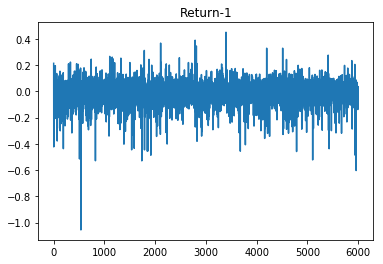

In [140]:
import matplotlib.pyplot as plt
import pandas as pd

ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

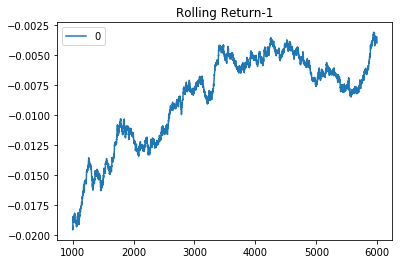

In [141]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

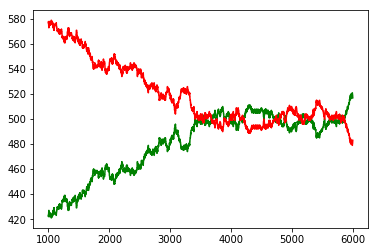

In [142]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

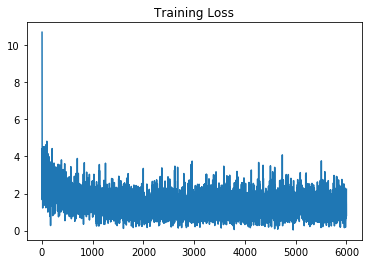

In [111]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

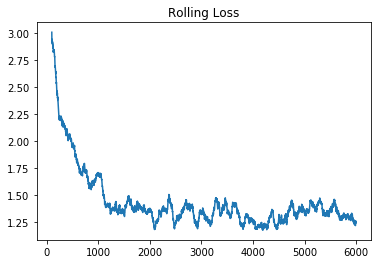

In [112]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

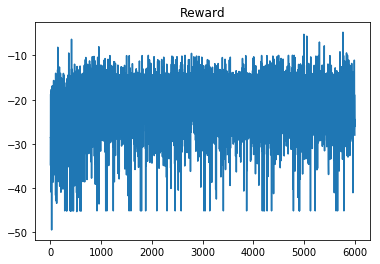

In [113]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

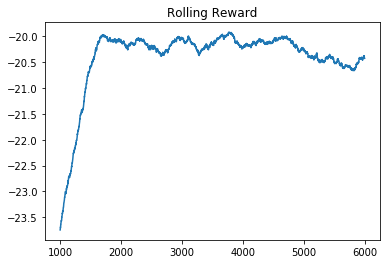

In [114]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

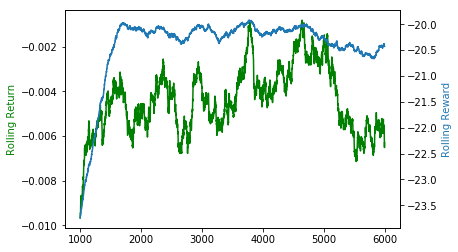

In [115]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

### Testing

Function to run episode with random actions:

In [116]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

Function to run episode with trained model and random model:

In [117]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        
        start_date = pd.to_datetime(plt_df.index[0]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(plt_df.index[-1]).strftime('%Y-%m-%d')
        
        #Plot some days before the start of the episode to see recent trends             
        start_index = np.where((raw_data.Open==plt_df.iloc[0].Open)&(raw_data.Close==plt_df.iloc[0].Close)&(raw_data.Volume==plt_df.iloc[0].Volume))[0][0]
        end_index = np.where((raw_data.Open==plt_df.iloc[-1].Open)&(raw_data.Close==plt_df.iloc[-1].Close)&(raw_data.Volume==plt_df.iloc[-1].Volume))[0][0]
        
        plt.plot(raw_data.iloc[max(start_index-10,0):start_index+1].index,raw_data.iloc[max(start_index-10,0):start_index+1].Open,'--',color='gray')
        plt.plot(raw_data.iloc[start_index:end_index+1].index,raw_data.iloc[start_index:end_index+1].Open,color='black')
        
        plt.ylim(min(raw_data.iloc[max(start_index-10,0):end_index].Open)*0.95, max(raw_data.iloc[max(start_index-10,0):end_index].Open)*1.05)
        plt.ylabel('Open Price')
        
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Sells
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.02*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.02*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Set up environment for testing:

In [118]:
import gym
import gym_market
import numpy as np
import imp

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_test, 
                  'raw_data':raw_data_test}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Run tests:

Return: 0.981
Random return: 1.058


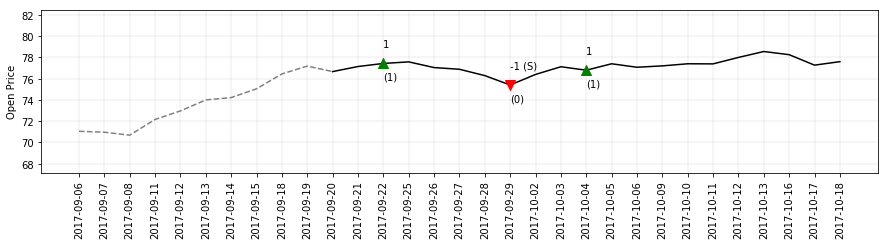

In [130]:
episode_count = 1

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data_test,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [73]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (150 episodes): 1.012
Average random return (150 episodes): 0.970
